In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import datetime as dt
import os
import glob
import json
import sys
from decimal import getcontext

# Add current directory to path for importing calculator
sys.path.append('./research/simulation')

# Set high precision for accurate calculations
getcontext().prec = 50

In [21]:
# ========== CONFIGURATION PARAMETERS ==========

# Trading pair and pool configuration
SYMBOL = "ETHUSDC"
POOL_ADDRESS = "0xc6962004f452be9203591991d15f6b388e09e8d0"
IS_PAIR_TOGGLED = False  # Set to True if you want to flip the price ratio

# Position parameters
START_TIME = dt.datetime(year=2025, month=5, day=7, hour=0, minute=0, second=0, microsecond=0)
END_TIME = dt.datetime(year=2025, month=5, day=31, hour=0, minute=0, second=0, microsecond=0)
UPPER_PRICE = 2700  # Upper price bound
LOWER_PRICE = 2350  # Lower price bound

# Deposit amount for fee calculation (in USD)
DEPOSIT_AMOUNT_USD = 200

print(f"📋 Configuration:")
print(f"   Symbol: {SYMBOL}")
print(f"   Pool: {POOL_ADDRESS}")
print(f"   Period: {START_TIME.strftime('%Y-%m-%d')} to {END_TIME.strftime('%Y-%m-%d')} ({(END_TIME - START_TIME).days} days)")
print(f"   Price Range: ${LOWER_PRICE:,.2f} - ${UPPER_PRICE:,.2f}")
print(f"   Center Price: ${(UPPER_PRICE + LOWER_PRICE) / 2:,.2f}")
print(f"   Deposit Amount: ${DEPOSIT_AMOUNT_USD:,.2f}")

📋 Configuration:
   Symbol: ETHUSDC
   Pool: 0xc6962004f452be9203591991d15f6b388e09e8d0
   Period: 2025-05-07 to 2025-05-31 (24 days)
   Price Range: $2,350.00 - $2,700.00
   Center Price: $2,525.00
   Deposit Amount: $200.00


In [22]:
# Load data from CSV file
def find_csv():
    csv_files = glob.glob(f"./research/simulation/data/{SYMBOL}_hourly_data_*.csv")
    return csv_files

def load_data(filename=None):    
    if filename is None:
        # Try to find CSV files automatically
        csv_files = find_csv()
        
        if not csv_files:
            print("No CSV files found in current directory.")
            print("Please ensure you have run the data fetching notebook first.")
            return None
        
        # Use the most recent file
        filename = max(csv_files, key=os.path.getctime)
        print(f"Found {len(csv_files)} CSV file(s)")
        print(f"Using most recent file: {filename}")
    
    try:
        # Load the CSV file
        df = pd.read_csv(filename)
        
        # Convert timestamp columns to datetime
        df['open_time'] = pd.to_datetime(df['open_time'])
        df['close_time'] = pd.to_datetime(df['close_time'])
        
        # Ensure data types are correct
        price_columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
                         'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
        for col in price_columns:
            if col in df.columns:
                df[col] = df[col].astype(float)
        
        # Sort by open_time to ensure chronological order
        df = df.sort_values('open_time').reset_index(drop=True)
        
        print(f"Successfully loaded {SYMBOL} data!")
        print(f"Dataset: {len(df):,} hourly records")
        print(f"Period: {df['open_time'].min().strftime('%Y-%m-%d %H:%M')} to {df['open_time'].max().strftime('%Y-%m-%d %H:%M')}")
        
        return df
        
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        print("Please check the filename and try again.")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_data()


Found 1 CSV file(s)
Using most recent file: ./research/simulation/data/ETHUSDC_hourly_data_20240701_20250701.csv
Successfully loaded ETHUSDC data!
Dataset: 8,761 hourly records
Period: 2024-06-30 17:00 to 2025-06-30 17:00


In [23]:
# Load pool data and calculate fees
def load_pool_data_and_calculate_fees(pool_address, deposit_amount_usd, lower_price, upper_price, 
                                       start_time, end_time, price_data_df, is_pair_toggled=False):
    """
    Load pool data and calculate estimated fees for the position.
    
    Args:
        pool_address: Pool address (lowercase)
        deposit_amount_usd: Deposit amount in USD
        lower_price: Lower price bound
        upper_price: Upper price bound
        start_time: Position start time
        end_time: Position end time
        price_data_df: DataFrame with price data
        is_pair_toggled: Whether to toggle the pair
        
    Returns:
        Dictionary with fee calculation results
    """
    try:
        from uniswapv3_calculator import UniswapV3Calculator
        
        pool_addr = pool_address.lower()
        data_path = f"./research/simulation/data"
        
        # Load pool data
        print("📂 Loading pool data...")
        pool_day_data = pd.read_csv(f'{data_path}/{pool_addr}_pool_day_data.csv')
        pool_ticks_data = pd.read_csv(f'{data_path}/{pool_addr}_pool_ticks_data.csv')
        
        with open(f'{data_path}/{pool_addr}_token_data.json', 'r') as f:
            token_data = json.load(f)
        
        # Verify pool address
        if token_data['pool']['id'] != pool_addr:
            raise ValueError(f"Pool address mismatch: {token_data['pool']['id']} != {pool_addr}")
        
        # Extract pool parameters
        token0_decimal = int(token_data['token0']['decimals'])
        token1_decimal = int(token_data['token1']['decimals'])
        fee_tier = int(token_data['pool']['feeTier']) / 1_000_000
        price_usd_x = float(token_data['token0']['priceUSD'])
        price_usd_y = float(token_data['token1']['priceUSD'])
        
        print(f"✅ Loaded pool data:")
        print(f"   Token0: {token_data['token0']['symbol']} (${price_usd_x:.4f})")
        print(f"   Token1: {token_data['token1']['symbol']} (${price_usd_y:.4f})")
        print(f"   Fee Tier: {fee_tier * 100}%")
        
        # Initialize calculator
        calculator = UniswapV3Calculator(
            pool_day_data, pool_ticks_data, fee_tier, 
            token0_decimal, token1_decimal, is_pair_toggled
        )
        
        # Filter price data for the specified period
        mask = (price_data_df['open_time'] >= start_time) & (price_data_df['open_time'] <= end_time)
        period_data = price_data_df[mask].copy()
        
        if period_data.empty:
            print("⚠️  No price data available for the specified period")
            return None
        
        # Calculate average price during the period
        avg_price = period_data['close'].mean()
        
        # Check if position is in range
        in_range = lower_price <= avg_price <= upper_price
        print(f"\n💡 Position Analysis:")
        print(f"   Average Price: ${avg_price:.2f}")
        print(f"   Position In Range: {in_range}")
        
        if not in_range:
            print("⚠️  Warning: Average price is outside the specified range!")
            print("   Fee calculation assumes price is at the center of your range")
            # Use center price for calculation
            price_assumption = (lower_price + upper_price) / 2
        else:
            price_assumption = avg_price
        
        print(f"\n💰 Step 1: Calculating Token Amounts...")
        
        # Calculate token amounts
        amount0, amount1, basic_liquidity_delta = calculator.get_tokens_amount_from_deposit_amount_usd(
            price_assumption, lower_price, upper_price, 
            price_usd_x, price_usd_y, deposit_amount_usd
        )
        
        print(f"   Amount0: {amount0:.8f} {token_data['token0']['symbol']}")
        print(f"   Amount1: {amount1:.8f} {token_data['token1']['symbol']}")
        
        # Calculate position liquidity (deltaL)
        print(f"\n🌊 Step 2: Calculating Position Liquidity (deltaL)...")
        corrected_delta_l = calculator.calculate_position_liquidity(
            amount0, amount1, lower_price, upper_price, price_assumption
        )
        
        # Get total liquidity at current tick
        print(f"\n📊 Step 3: Getting Total Liquidity...")
        current_tick = calculator.get_tick_from_price(price_assumption)
        print(f"   Current tick: {current_tick}")
        total_liquidity = calculator.get_liquidity_from_tick(current_tick)
        print(f"   Total Liquidity (L): {total_liquidity:.2e}")
        
        # Calculate fees
        print(f"\n💸 Step 4: Calculating Fees...")
        volume_24h = calculator.get_volume_24h_avg()
        estimated_fee_24h = calculator.estimate_fee(corrected_delta_l, abs(total_liquidity), volume_24h)
        
        # Calculate fees for the actual position duration
        duration_days = (end_time - start_time).days
        duration_hours = (end_time - start_time).total_seconds() / 3600
        
        # Adjust for time in range
        in_range_data = period_data[(period_data['close'] >= lower_price) & 
                                     (period_data['close'] <= upper_price)]
        time_in_range_pct = len(in_range_data) / len(period_data) if len(period_data) > 0 else 0
        
        # Estimated fees adjusted for time in range
        estimated_fee_period = estimated_fee_24h * duration_days * time_in_range_pct
        monthly_fee = estimated_fee_24h * 30 * time_in_range_pct
        yearly_fee = estimated_fee_24h * 365 * time_in_range_pct
        
        daily_return_pct = (estimated_fee_24h / deposit_amount_usd) * 100
        period_return_pct = (estimated_fee_period / deposit_amount_usd) * 100
        yearly_apr_pct = (yearly_fee / deposit_amount_usd) * 100
        
        results = {
            'token0_symbol': token_data['token0']['symbol'],
            'token1_symbol': token_data['token1']['symbol'],
            'fee_tier': fee_tier,
            'amount0': amount0,
            'amount1': amount1,
            'liquidity_delta': corrected_delta_l,
            'total_liquidity': total_liquidity,
            'volume_24h': volume_24h,
            'daily_fee': estimated_fee_24h,
            'period_fee': estimated_fee_period,
            'monthly_fee': monthly_fee,
            'yearly_fee': yearly_fee,
            'daily_return_pct': daily_return_pct,
            'period_return_pct': period_return_pct,
            'yearly_apr_pct': yearly_apr_pct,
            'time_in_range_pct': time_in_range_pct * 100,
            'duration_days': duration_days,
            'price_assumption': price_assumption
        }
        
        print(f"\n✅ Fee Calculation Results:")
        print(f"   Time in Range: {time_in_range_pct * 100:.1f}%")
        print(f"   Daily Fees (if fully in range): ${estimated_fee_24h:.2f}")
        print(f"   Estimated Fees for {duration_days} days: ${estimated_fee_period:.2f}")
        print(f"   Est. Monthly Fees: ${monthly_fee:.2f}")
        print(f"   Est. Yearly Fees: ${yearly_fee:.2f}")
        print(f"   Period Return: {period_return_pct:.2f}%")
        print(f"   Annualized APR: {yearly_apr_pct:.2f}%")
        
        return results
        
    except FileNotFoundError as e:
        print(f"❌ Error: Pool data files not found for {pool_address}")
        print(f"   Make sure the following files exist in ./research/simulation/data/:")
        print(f"   - {pool_address}_pool_day_data.csv")
        print(f"   - {pool_address}_pool_ticks_data.csv")
        print(f"   - {pool_address}_token_data.json")
        return None
    except Exception as e:
        print(f"❌ Error calculating fees: {e}")
        import traceback
        traceback.print_exc()
        return None

# Calculate fees if data is loaded
fee_results = None
if df is not None:
    print("🚀 Starting fee calculation...")
    fee_results = load_pool_data_and_calculate_fees(
        POOL_ADDRESS, DEPOSIT_AMOUNT_USD, LOWER_PRICE, UPPER_PRICE,
        START_TIME, END_TIME, df, IS_PAIR_TOGGLED
    )


🚀 Starting fee calculation...
📂 Loading pool data...
✅ Loaded pool data:
   Token0: WETH ($3578.8486)
   Token1: USDC ($0.9977)
   Fee Tier: 0.05%
Current price (token0/token1): 0.000287517711
Current price (token1/token0): 3478.05

💡 Position Analysis:
   Average Price: $2491.47
   Position In Range: True

💰 Step 1: Calculating Token Amounts...
   Amount0: 0.03706118 WETH
   Amount1: 67.51958881 USDC

🌊 Step 2: Calculating Position Liquidity (deltaL)...
deltaL: 4.70e+13

📊 Step 3: Getting Total Liquidity...
   Current tick: -198113
   Total Liquidity (L): -4.91e+17

💸 Step 4: Calculating Fees...
Average 24h volume (last 7 days): $185,312,529.52

✅ Fee Calculation Results:
   Time in Range: 85.1%
   Daily Fees (if fully in range): $8.86
   Estimated Fees for 24 days: $180.86
   Est. Monthly Fees: $226.08
   Est. Yearly Fees: $2750.63
   Period Return: 90.43%
   Annualized APR: 1375.31%


In [24]:
def create_range_visualization(df, start_time, end_time, upper_price, lower_price, fee_results=None):
    """
    Visualize price data with a rectangle showing the liquidity provision range.
    
    Args:
        df: DataFrame with price data
        start_time: Start time for liquidity provision (datetime)
        end_time: End time for liquidity provision (datetime)
        upper_price: Upper price bound for liquidity provision
        lower_price: Lower price bound for liquidity provision
        fee_results: Optional dictionary with fee calculation results
    """
    if df is None:
        print("❌ No data available for visualization")
        return
    
    # Create figure
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Plot the full price history
    ax.plot(df['open_time'], df['close'], 
            color='blue', linewidth=1.5, label=f'{SYMBOL} Close Price', alpha=0.7, zorder=3)
    
    # Filter data within the specified time range for highlighting
    mask = (df['open_time'] >= start_time) & (df['open_time'] <= end_time)
    df_range = df[mask].copy()
    
    if not df_range.empty:
        # Highlight the price during the position period
        ax.plot(df_range['open_time'], df_range['close'], 
                color='orange', linewidth=2.5, label='Price during Position', zorder=4)
    
    # Create the liquidity range rectangle
    start_date_num = mdates.date2num(start_time)
    end_date_num = mdates.date2num(end_time)
    width = end_date_num - start_date_num
    height = upper_price - lower_price
    
    # Draw the rectangle
    rect = Rectangle((start_date_num, lower_price), width, height,
                     facecolor='green', alpha=0.2, 
                     edgecolor='darkgreen', linewidth=2,
                     label='Liquidity Range', zorder=2)
    ax.add_patch(rect)
    
    # Draw horizontal lines for upper and lower bounds
    ax.hlines(y=upper_price, xmin=start_date_num, xmax=end_date_num,
             colors='darkgreen', linestyles='--', linewidth=2, 
             label=f'Upper Bound: ${upper_price:,.2f}', zorder=5)
    ax.hlines(y=lower_price, xmin=start_date_num, xmax=end_date_num,
             colors='darkgreen', linestyles='--', linewidth=2,
             label=f'Lower Bound: ${lower_price:,.2f}', zorder=5)
    
    # Draw vertical lines for start and end time
    ax.axvline(x=start_time, color='red', linestyle='--', linewidth=1.5, 
               alpha=0.7, label='Position Start', zorder=5)
    ax.axvline(x=end_time, color='red', linestyle='--', linewidth=1.5,
               alpha=0.7, label='Position End', zorder=5)
    
    # Calculate center price
    center_price = (upper_price + lower_price) / 2
    ax.hlines(y=center_price, xmin=start_date_num, xmax=end_date_num,
             colors='purple', linestyles=':', linewidth=1.5,
             label=f'Center: ${center_price:,.2f}', alpha=0.8, zorder=5)
    
    # Formatting
    ax.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax.set_ylabel('Price (USD)', fontsize=14, fontweight='bold')
    ax.set_title(f'{SYMBOL} Liquidity Position Visualization',
                fontsize=16, fontweight='bold', pad=20)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    
    # Format y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.2f}'))
    
    # Grid and legend
    ax.grid(True, alpha=0.3, zorder=0)
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    
    # Add info box
    range_width = ((upper_price - lower_price) / center_price) * 100
    info_text = f"Position Details:\n"
    info_text += f"Duration: {(end_time - start_time).days} days\n"
    info_text += f"Price Range: ${lower_price:,.2f} - ${upper_price:,.2f}\n"
    info_text += f"Range Width: ±{range_width/2:.2f}%\n"
    
    if not df_range.empty:
        in_range = df_range[(df_range['close'] >= lower_price) & (df_range['close'] <= upper_price)]
        in_range_pct = (len(in_range) / len(df_range)) * 100
        info_text += f"In Range: {in_range_pct:.1f}% of time\n"
    
    # Add fee information if available
    if fee_results is not None:
        info_text += f"\n💰 Fee Earnings:\n"
        info_text += f"Period Fees: ${fee_results['period_fee']:.2f}\n"
        info_text += f"Period Return: {fee_results['period_return_pct']:.2f}%\n"
        info_text += f"Annualized APR: {fee_results['yearly_apr_pct']:.1f}%"
    
    ax.text(0.02, 0.98, info_text, 
           transform=ax.transAxes, fontsize=10,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    if not df_range.empty:
        print("\n📊 POSITION STATISTICS")
        print("=" * 50)
        print(f"Position Duration: {(end_time - start_time).days} days ({(end_time - start_time).total_seconds() / 3600:.1f} hours)")
        print(f"Price Range: ${lower_price:,.2f} - ${upper_price:,.2f}")
        print(f"Center Price: ${center_price:,.2f}")
        print(f"Range Width: ±{range_width/2:.2f}%")
        print(f"\n📈 PRICE BEHAVIOR DURING POSITION")
        print("-" * 50)
        in_range = df_range[(df_range['close'] >= lower_price) & (df_range['close'] <= upper_price)]
        out_of_range = df_range[(df_range['close'] > upper_price) | (df_range['close'] < lower_price)]
        print(f"Hours in range: {len(in_range)} ({len(in_range)/len(df_range)*100:.1f}%)")
        print(f"Hours out of range: {len(out_of_range)} ({len(out_of_range)/len(df_range)*100:.1f}%)")
        print(f"Min price: ${df_range['close'].min():,.2f}")
        print(f"Max price: ${df_range['close'].max():,.2f}")
        print(f"Avg price: ${df_range['close'].mean():,.2f}")
        
        # Check if price ever went above or below
        above = df_range[df_range['close'] > upper_price]
        below = df_range[df_range['close'] < lower_price]
        if not above.empty:
            print(f"\n⚠️  Price exceeded upper bound {len(above)} times")
            print(f"   First time: {above.iloc[0]['open_time'].strftime('%Y-%m-%d %H:%M')}")
            print(f"   Max price: ${above['close'].max():,.2f}")
        if not below.empty:
            print(f"\n⚠️  Price fell below lower bound {len(below)} times")
            print(f"   First time: {below.iloc[0]['open_time'].strftime('%Y-%m-%d %H:%M')}")
            print(f"   Min price: ${below['close'].min():,.2f}")


🎨 Creating visualization...


/tmp/nix-shell.as6InK/ipykernel_295327/1870796797.py:108: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/nix/store/ww8gzcd20s0m51zg04bvdlrp6fg7v2fj-python3.11-ipython-9.5.0/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


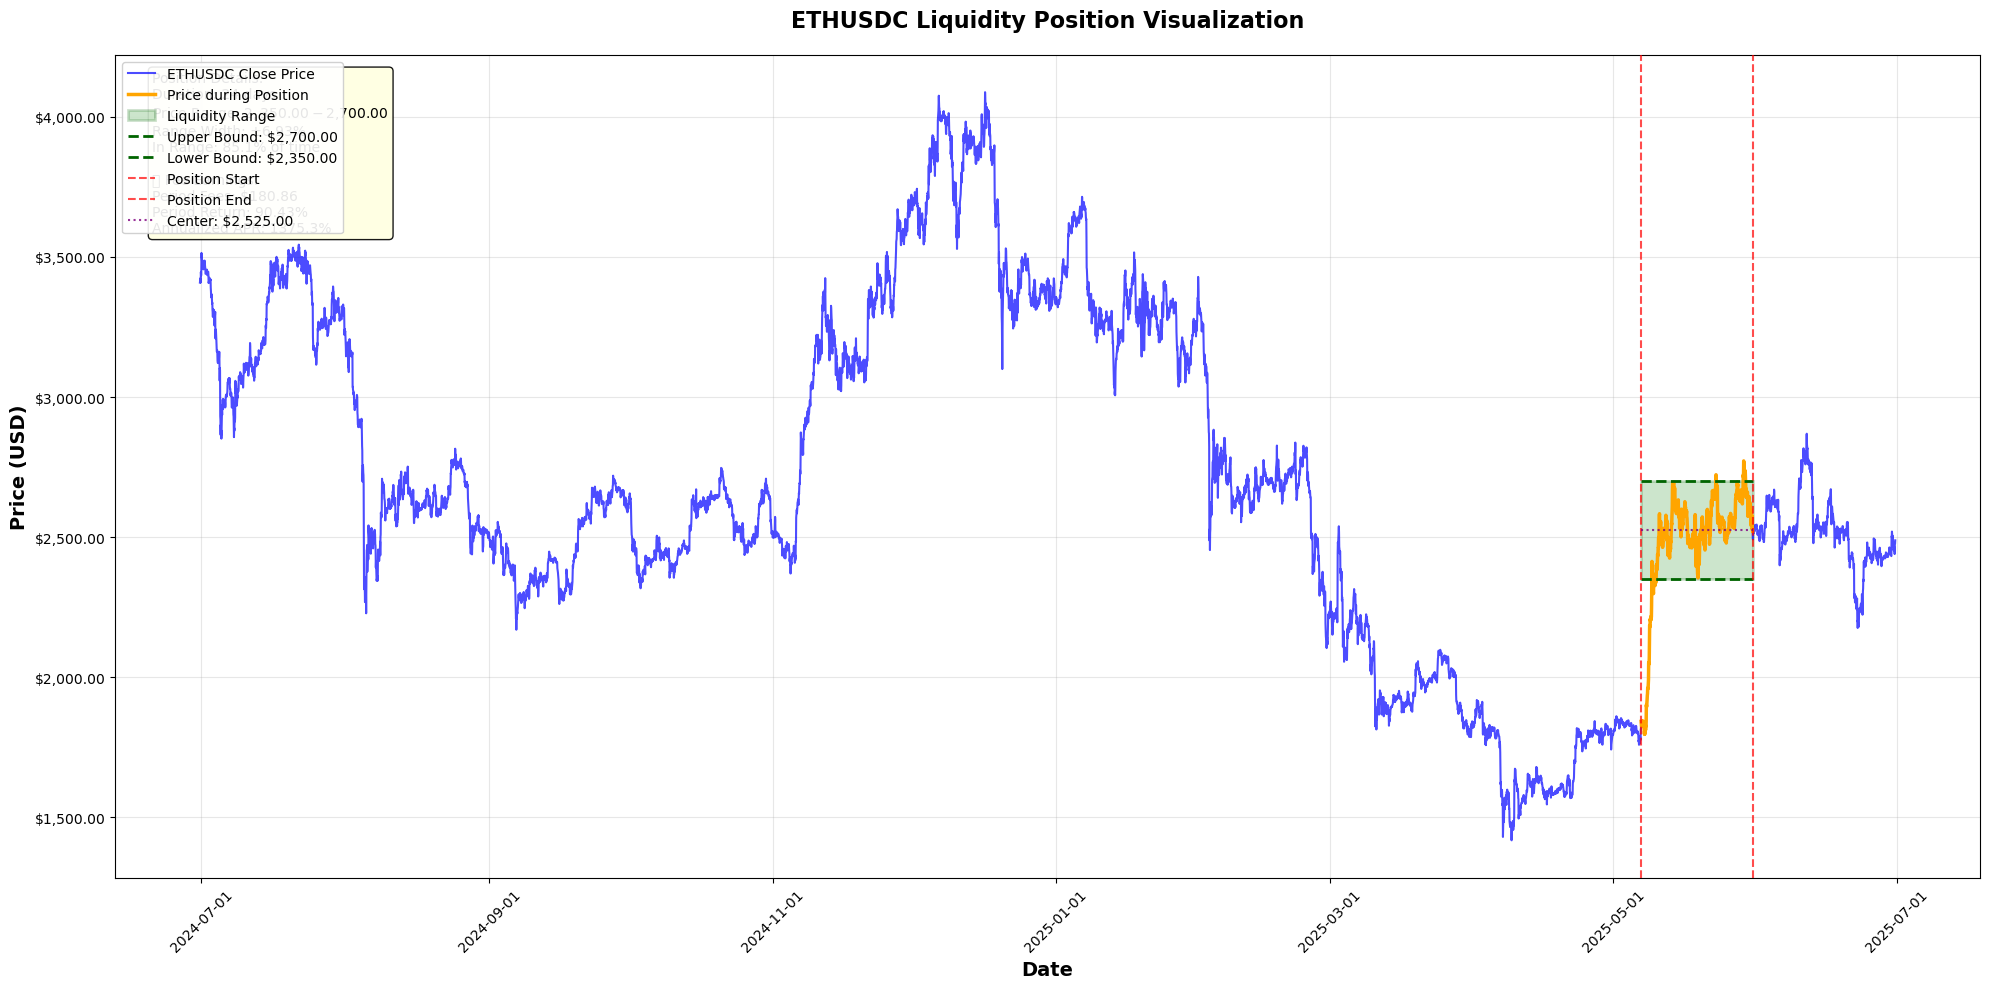


📊 POSITION STATISTICS
Position Duration: 24 days (576.0 hours)
Price Range: $2,350.00 - $2,700.00
Center Price: $2,525.00
Range Width: ±6.93%

📈 PRICE BEHAVIOR DURING POSITION
--------------------------------------------------
Hours in range: 491 (85.1%)
Hours out of range: 86 (14.9%)
Min price: $1,796.04
Max price: $2,771.80
Avg price: $2,491.47

⚠️  Price exceeded upper bound 14 times
   First time: 2025-05-23 02:00
   Max price: $2,771.80

⚠️  Price fell below lower bound 72 times
   First time: 2025-05-07 00:00
   Min price: $1,796.04
✅ Visualization complete!


In [25]:
# Create visualization with fee information
if df is not None:
    print("\n🎨 Creating visualization...")
    create_range_visualization(df, START_TIME, END_TIME, UPPER_PRICE, LOWER_PRICE, fee_results)
    print("✅ Visualization complete!")

## 📖 Notebook Guide: Liquidity Position Visualization & Fee Calculation

### Overview
This notebook helps you visualize and analyze Uniswap V3 liquidity positions by:
1. Loading historical price data for a trading pair
2. Defining your liquidity position (time range and price range)
3. Calculating estimated fee earnings based on actual pool data
4. Visualizing everything with an interactive chart

---

### 🔧 Configuration Parameters (Cell 1)

#### Trading Pair Configuration:
- **`SYMBOL`**: Trading pair symbol (e.g., "ETHUSDC", "BTCUSDT")
  - Must match the CSV file name in `./research/simulation/data/`
  
- **`POOL_ADDRESS`**: Uniswap V3 pool address (lowercase)
  - Used to load pool data for accurate fee calculation
  - Available pools in data folder:
    - `0xcda53b1f66614552f834ceef361a8d12a0b8dad8` - ARB/USDC 0.05% pool
    - `0xc6962004f452be9203591991d15f6b388e09e8d0` - Another available pool
  
- **`IS_PAIR_TOGGLED`**: Set to `True` to flip the price ratio (e.g., USDC/ETH instead of ETH/USDC)

#### Position Parameters:
- **`START_TIME`**: When you start providing liquidity
- **`END_TIME`**: When you stop providing liquidity
- **`UPPER_PRICE`**: Upper price bound of your position
- **`LOWER_PRICE`**: Lower price bound of your position

#### Fee Calculation:
- **`DEPOSIT_AMOUNT_USD`**: Total USD value to deposit (e.g., $1000)
  - Used to calculate your position size and potential fees

---

### 📊 Understanding the Visualization

The chart shows:
1. **Blue Line**: Full price history of the trading pair
2. **Orange Line**: Price during your position period (highlighted)
3. **Green Rectangle**: Your liquidity provision range
   - Width = time duration (START_TIME to END_TIME)
   - Height = price range (LOWER_PRICE to UPPER_PRICE)
4. **Red Dashed Lines**: Position start and end times
5. **Green Dashed Lines**: Upper and lower price bounds
6. **Purple Dotted Line**: Center price of your range
7. **Red X Markers**: Times when price went out of range (no fees earned)

**Info Box** displays:
- Position duration, price range, and range width
- Percentage of time price was in range
- **Fee earnings**: Estimated fees for the period, return %, and APR

---

### 💰 Fee Calculation Methodology

The notebook uses the Uniswap V3 fee formula:
```
Fee = (Your Liquidity / Total Pool Liquidity) × Pool Fee Tier × Trading Volume
```

**Steps:**
1. **Token Amounts**: Calculate how many of each token you'd deposit
2. **Position Liquidity (ΔL)**: Calculate your position's liquidity contribution
3. **Total Liquidity (L)**: Get the pool's total liquidity at your price range
4. **Volume**: Use average 24h trading volume from pool data
5. **Time Adjustment**: Fees are only earned when price is **in range**

**Key Metrics:**
- **Daily Fee**: Estimated fee per day (if price stays in range 100% of time)
- **Period Fee**: Actual estimated fee for your time period × time-in-range %
- **Monthly/Yearly Fees**: Extrapolated estimates
- **APR**: Annualized return percentage

---

### ⚠️ Important Notes

1. **Fee Estimates are Approximations**:
   - Based on recent trading volume (last 7 days average)
   - Assumes constant volume and liquidity
   - Real fees will vary based on market conditions

2. **Time in Range Matters**:
   - You only earn fees when price is within your range
   - The calculation adjusts for actual time-in-range percentage
   - Wider ranges = more time in range but lower fee concentration

3. **Pool Data Requirements**:
   - The pool address must have corresponding data files in `./research/simulation/data/`:
     - `{pool_address}_pool_day_data.csv`
     - `{pool_address}_pool_ticks_data.csv`
     - `{pool_address}_token_data.json`

4. **Price Data vs Pool Data**:
   - `SYMBOL` loads Binance price data for visualization
   - `POOL_ADDRESS` loads Uniswap pool data for fee calculation
   - Make sure they represent the same trading pair!

---

### 🎯 Example Use Cases

**1. Conservative Position (Wide Range)**
```python
UPPER_PRICE = 3000
LOWER_PRICE = 2000
# Result: High time in range, lower APR
```

**2. Aggressive Position (Narrow Range)**
```python
UPPER_PRICE = 2600
LOWER_PRICE = 2400
# Result: Lower time in range, higher APR (when in range)
```

**3. Different Time Periods**
```python
# Short term (1 month)
START_TIME = dt.datetime(2025, 5, 1, 0, 0, 0)
END_TIME = dt.datetime(2025, 5, 31, 0, 0, 0)

# Long term (6 months)
START_TIME = dt.datetime(2024, 12, 1, 0, 0, 0)
END_TIME = dt.datetime(2025, 5, 31, 0, 0, 0)
```

---

### 🚀 Quick Start

1. **Modify Cell 1**: Set your parameters (symbol, pool, dates, prices, deposit amount)
2. **Run All Cells**: Execute all cells in order
3. **Review Output**: 
   - Fee calculation results (detailed breakdown)
   - Visualization chart with position overlay
   - Position statistics and performance metrics

---

### 📚 Additional Resources

- Uniswap V3 Whitepaper: Understanding concentrated liquidity
- Pool data source: Uniswap V3 Subgraph
- Price data source: Binance API

---

### 💡 Tips for Optimization

1. **Test Multiple Ranges**: Run notebook with different UPPER_PRICE/LOWER_PRICE to compare
2. **Analyze Historical Periods**: Use past data to see how strategies would have performed
3. **Compare Pools**: Try different POOL_ADDRESS values (same pair, different fee tiers)
4. **Consider Volatility**: Wider ranges for volatile pairs, narrower for stable pairs
